# Extracting edge level bird features 🐦
This notebook details the process of extracting edge level bird features. It builds upon [`experimental/birds.ipynb`](/notebooks/experimental/birds.ipynb). It contains:
- [Data](#data)
- [Processing](#processing---extracting-edge-level-bird-attributes)
- [Exporting data](#dump-data)
- [Extra Analysis](#extra-analysis)

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as cx
import osmnx as ox
import networkx as nx
import spaghetti
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

from collections import Counter

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
/opt/conda/lib/python3.9/site-packages/spaghetti/network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


## Data
### Birds
Start by loading in the birds dataset. This data comes from [DOFbasen](https://dofbasen.dk/), and contains all birds observations from 2020-01-01 to 2024-04-17 in DOF's area of Greater Copenhagen. 

In [2]:
birds = pd.read_csv('../data/raw/birds.csv')
birds = birds.drop(columns='Unnamed: 0')
birds.head()

,Dato,Turtidfra,Turtidtil,Loknr,Loknavn,Artnr,Artnavn,Latin,Sortering,Antal,...,Hemmelig,Kvalitet,Turid,Obsid,DOF_afdeling,lok_laengdegrad,lok_breddegrad,obs_laengdegrad,obs_breddegrad,radius
0,2024-04-17,06:11,NaN,101072,Amager Fælled,110,Nordisk Lappedykker,Podiceps auritus,1410,1,...,0,1,5325297,34145618,DOF København,12.573829,55.649143,12.585059,55.652415,50.0
1,2024-04-17,NaN,NaN,101013,Utterslev Mose Del III (Østmosen),1580,Kortnæbbet Gås,Anser brachyrhynchus,310,1,...,0,1,5325713,34148597,DOF København,12.519717,55.719944,12.515982,55.717640,31.0
2,2024-04-17,08:22,NaN,171142,Porsemosen (Høje Taastrup / Egedal),1580,Kortnæbbet Gås,Anser brachyrhynchus,310,1,...,0,1,5325489,34146804,DOF København,12.299448,55.694660,12.314819,55.694586,50.0
3,2024-04-17,NaN,NaN,205011,Furesøen eksl. Kalvene,2390,Rød Glente,Milvus milvus,4400,1,...,0,1,5325664,34148195,DOF København,12.418628,55.793140,12.407985,55.810542,164.0
4,2024-04-17,NaN,NaN,905378,Vesterled Sø og Tibberup Å (Hareskovby),6700,Ringdue,Columba palumbus,1470,1,...,0,1,5325356,34145928,DOF København,12.403287,55.754642,12.398897,55.751653,18.0


We process this data using `GeoPandas`.

In [3]:
gdf = gpd.GeoDataFrame(
    birds, geometry=gpd.points_from_xy(birds.obs_laengdegrad, birds.obs_breddegrad), crs="EPSG:4326"
)

Since this data is located in Denmark, we use CRS _EPSG:25832_ to work with coordinates in metric units.

In [4]:
gdf = gdf.to_crs('EPSG:25832')

Since the dataset contains data from a greater area than Copenhagen, we remove all observations outside the area of interest aka Copenhagen and Frederiksberg.

In [5]:
# load shape of Copenhagen
geocodes = ['Københavns Kommune', 'Frederiksberg Kommune']
cph = ox.geocode_to_gdf(geocodes)
cph = cph.to_crs('EPSG:25832')
cph_poly = cph.dissolve().geometry.iloc[0]

# find intersecting bird observations
gdf['intersection_geometry'] = gdf.geometry.intersection(cph_poly)

# remove observations without exact coordinates
gdf = gdf[~gdf.intersection_geometry.is_empty]

/opt/conda/lib/python3.9/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))
/opt/conda/lib/python3.9/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


We can visualize the wrangled birds data as a scatter plot, which gives:

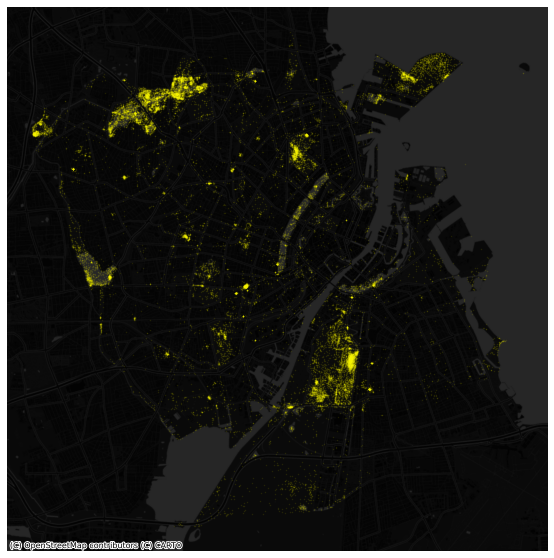

In [6]:
f, ax = plt.subplots(figsize=(10,10))
gdf.plot(
    markersize=0.25,
    c="xkcd:bright yellow",
    alpha=0.1,
    ax=ax)
cx.add_basemap(source=cx.providers.CartoDB.DarkMatterNoLabels, crs=gdf.crs, ax=ax)
ax.set_axis_off()

### Bike paths
To get the bike paths, we use _OpenStreetMap_ with the library `osmnx`. We query OSM with the _Københavns Kommune_ and _Frederiksberg Kommune_ geocodes. We specify `network_type='bike'` to strictly get bike paths.

In [7]:
G = ox.graph_from_place(geocodes, network_type='bike')
G = ox.project_graph(G, to_crs='EPSG:25832')

/opt/conda/lib/python3.9/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))
/opt/conda/lib/python3.9/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


Visualized, the bike path network looks like:

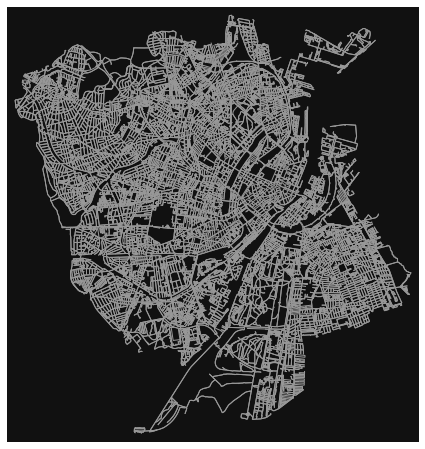

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [8]:
ox.plot_graph(G, node_size=0)

We also convert this network to `GeoDataFrame` enabling GeoPandas methods.

In [9]:
# convert graph to geodataframe
_, edges = ox.graph_to_gdfs(G)
edges.head()

osmid  oneway              name   highway  \
u          v          key                                                  
118725     298795432  0     27226011    True  Banegårdspladsen  tertiary   
           6357644306 0    140412993    True     Vesterbrogade  tertiary   
298795432  298795496  0    244360867    True  Banegårdspladsen  tertiary   
6357644306 2378383724 0    678991574    True     Vesterbrogade  tertiary   
           6357644350 0    679140293    True     Vesterbrogade  tertiary   

                          maxspeed   length  \
u          v          key                     
118725     298795432  0         30  112.872   
           6357644306 0         50   40.497   
298795432  298795496  0         30   89.801   
6357644306 2378383724 0         50   21.930   
           6357644350 0         50   23.056   

                                                                    geometry  \
u          v          key                                                      
118725     298795432  0    LINESTRING (724025.025 6175551.339, 724031.889...   
           6357644306 0    LINESTRING (724025.025 6175551.339, 724051.956...   
298795432  298795496  0    LINESTRING (724075.369 6175450.104, 724076.732...   
6357644306 2378383724 0    LINESTRING (724059.919 6175572.112, 724075.704...   
           6357644350 0    LINESTRING (724059.919 6175572.112, 724081.508...   

                          lanes bridge  ref service width access tunnel  \
u          v          key                                                 
118725     298795432  0     NaN    NaN  NaN     NaN   NaN    NaN    NaN   
           6357644306 0       2    NaN  NaN     NaN   NaN    NaN    NaN   
298795432  298795496  0     NaN    NaN  NaN     NaN   NaN    NaN    NaN   
6357644306 2378383724 0       2    NaN  NaN     NaN   NaN    NaN    NaN   
           6357644350 0       1    NaN  NaN     NaN   NaN    NaN    NaN   

                          junction  
u          v          key           
118725     298795432  0        NaN  
           6357644306 0        NaN  
298795432  298795496  0        NaN  
6357644306 2378383724 0        NaN  
           6357644350 0        NaN

## Processing - Extracting edge level bird attributes
There are a multitude of ways to process this data. Our approach is to use intersecting bird buffers. The approach entails creating a buffer around each bird observation, and for each edge, count the number of bird buffers they intersect with. We start by creating a buffer of $50$m around each bird observation.

In [10]:
# create a buffer around each observation
buffer_radius = 50  # radius (in meters due to EPSG:25832)
gdf['buffer'] = gdf.buffer(buffer_radius)
gdf_buffer = gdf.set_geometry('buffer')

We can plot these buffered birds to see higher density areas of interest.

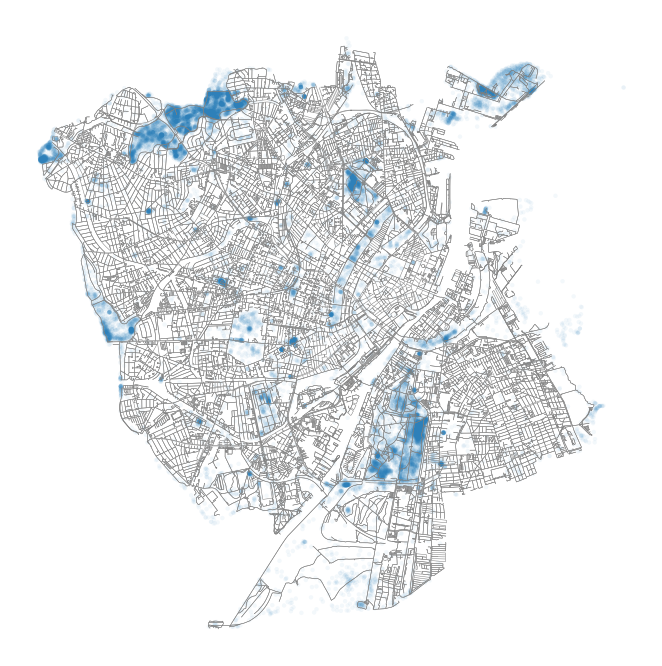

In [11]:
f, ax = plt.subplots(figsize=(12,12))

# plot street network
edges.plot(
    color='grey',
    linewidth=0.5,
    ax=ax
)

# plot buffers
gdf['buffer'].plot(
    alpha=.05,
    ax=ax
)

ax.set_axis_off()

We find the intersections between edges and birds through a spatial join.

In [12]:
intersections = edges.sjoin(gdf_buffer)
intersections = gpd.GeoDataFrame(
    intersections, 
    geometry=intersections.geometry_left, 
    crs=gdf.crs
)

These can be grouped by each edge and counted to find number of bird observations per street.

In [13]:
bird_counts = intersections.groupby(['u', 'v', 'key']).size()
bird_counts.name = 'birds'
bird_counts.head()

u       v           key
118725  298795432   0      8
        6357644306  0      3
118735  6511276293  0      1
        8977396171  0      1
118751  3574460115  0      1
Name: birds, dtype: int64

We left join these counts back onto the original edges, and fill null values with 0.

In [14]:
edges = edges.merge(bird_counts, left_index=True, right_index=True, how='left')
edges['birds'] = edges.birds.fillna(0)

Since some roads are longer than others, we normalize bird counts by path length.

In [15]:
edges['birds_per_m'] = edges['birds'] / edges['length']

Once processed, the wrangled data looks like:

In [16]:
edges.head()

osmid  oneway              name   highway  \
u          v          key                                                  
118725     298795432  0     27226011    True  Banegårdspladsen  tertiary   
           6357644306 0    140412993    True     Vesterbrogade  tertiary   
298795432  298795496  0    244360867    True  Banegårdspladsen  tertiary   
6357644306 2378383724 0    678991574    True     Vesterbrogade  tertiary   
           6357644350 0    679140293    True     Vesterbrogade  tertiary   

                          maxspeed   length  \
u          v          key                     
118725     298795432  0         30  112.872   
           6357644306 0         50   40.497   
298795432  298795496  0         30   89.801   
6357644306 2378383724 0         50   21.930   
           6357644350 0         50   23.056   

                                                                    geometry  \
u          v          key                                                      
118725     298795432  0    LINESTRING (724025.025 6175551.339, 724031.889...   
           6357644306 0    LINESTRING (724025.025 6175551.339, 724051.956...   
298795432  298795496  0    LINESTRING (724075.369 6175450.104, 724076.732...   
6357644306 2378383724 0    LINESTRING (724059.919 6175572.112, 724075.704...   
           6357644350 0    LINESTRING (724059.919 6175572.112, 724081.508...   

                          lanes bridge  ref service width access tunnel  \
u          v          key                                                 
118725     298795432  0     NaN    NaN  NaN     NaN   NaN    NaN    NaN   
           6357644306 0       2    NaN  NaN     NaN   NaN    NaN    NaN   
298795432  298795496  0     NaN    NaN  NaN     NaN   NaN    NaN    NaN   
6357644306 2378383724 0       2    NaN  NaN     NaN   NaN    NaN    NaN   
           6357644350 0       1    NaN  NaN     NaN   NaN    NaN    NaN   

                          junction  birds  birds_per_m  
u          v          key                               
118725     298795432  0        NaN    8.0     0.070877  
           6357644306 0        NaN    3.0     0.074080  
298795432  298795496  0        NaN    7.0     0.077950  
6357644306 2378383724 0        NaN    2.0     0.091199  
           6357644350 0        NaN    1.0     0.043373

## Dump data
Once the data is processed, we output it for further use of hygge analysis.

In [17]:
columns = ['u', 'v', 'key', 'birds', 'birds_per_m']
dump = edges.reset_index()[columns]
dump.head()

,u,v,key,birds,birds_per_m
0,118725,298795432,0,8.0,0.070877
1,118725,6357644306,0,3.0,0.074080
2,298795432,298795496,0,7.0,0.077950
3,6357644306,2378383724,0,2.0,0.091199
4,6357644306,6357644350,0,1.0,0.043373


Output the data to a .csv

In [18]:
dump.to_csv('../data/bird_edges.csv', index=False)

## Extra Analysis
Below, you will find various plots and visualizations that are cool 😎. They will not be commented much on, but are made to gain further insight into the geospatial dispertion of birds.

### KDE plot

Text(0.5, 1.0, 'KDE of photos in Tokyo')

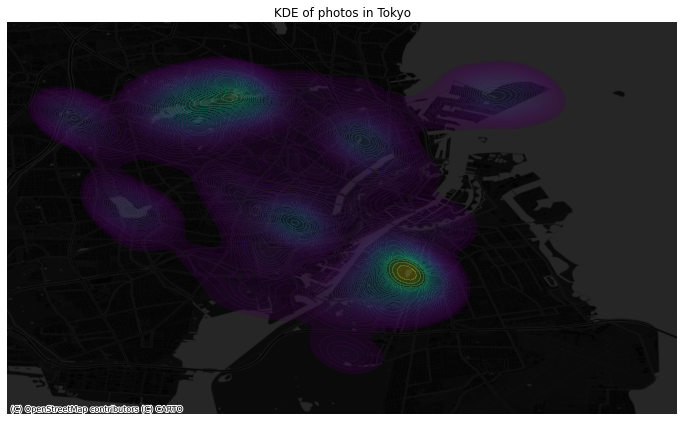

In [19]:
f, ax = plt.subplots(1, figsize=(12, 12))

sns.kdeplot(
    data=gdf,
    x='obs_laengdegrad', 
    y='obs_breddegrad', 
    n_levels=50, 
    shade=True,
    alpha=0.25,
    cmap="viridis"
)

ax.set_axis_off()
cx.add_basemap(
    ax, 
    crs="EPSG:4326",
    source=cx.providers.CartoDB.DarkMatterNoLabels
)
ax.set_title("KDE of photos in Tokyo")

### Bird streets with quantile birds per meter

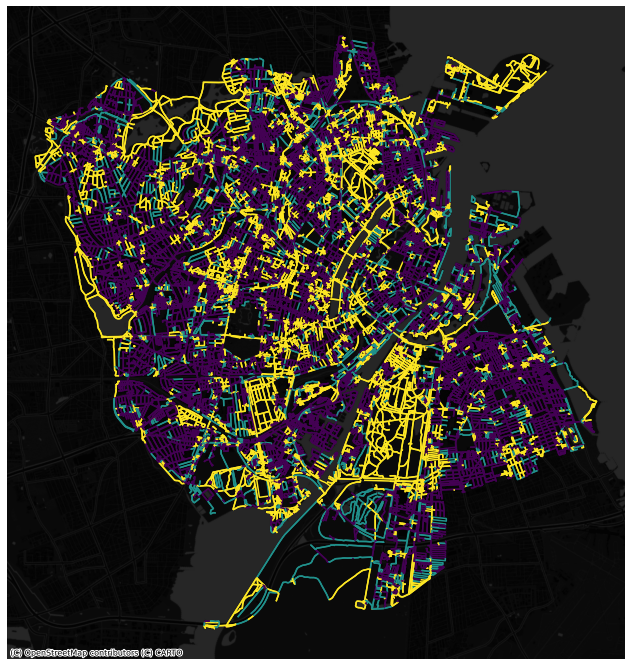

In [20]:
# plot streets with bird activity
f, ax = plt.subplots(figsize=(12,12))
edges.plot(
    column='birds_per_m',
    scheme='quantiles',
    k=3,
    ax=ax)
ax.set_axis_off()
cx.add_basemap(
    ax, 
    crs=edges.crs,
    source=cx.providers.CartoDB.DarkMatterNoLabels
)

### Point pattern with marginal distribution

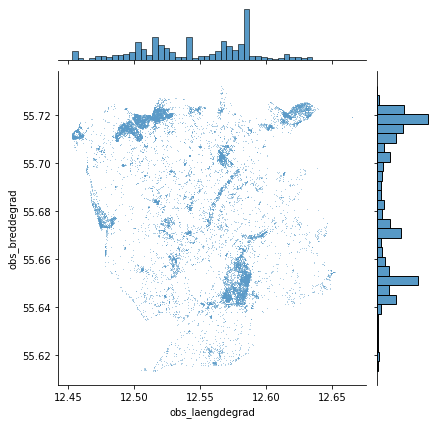

In [21]:
joint_axes = sns.jointplot(
    x='obs_laengdegrad', y='obs_breddegrad', data=gdf, s=0.5
)

### Point pattern of N most common bird types

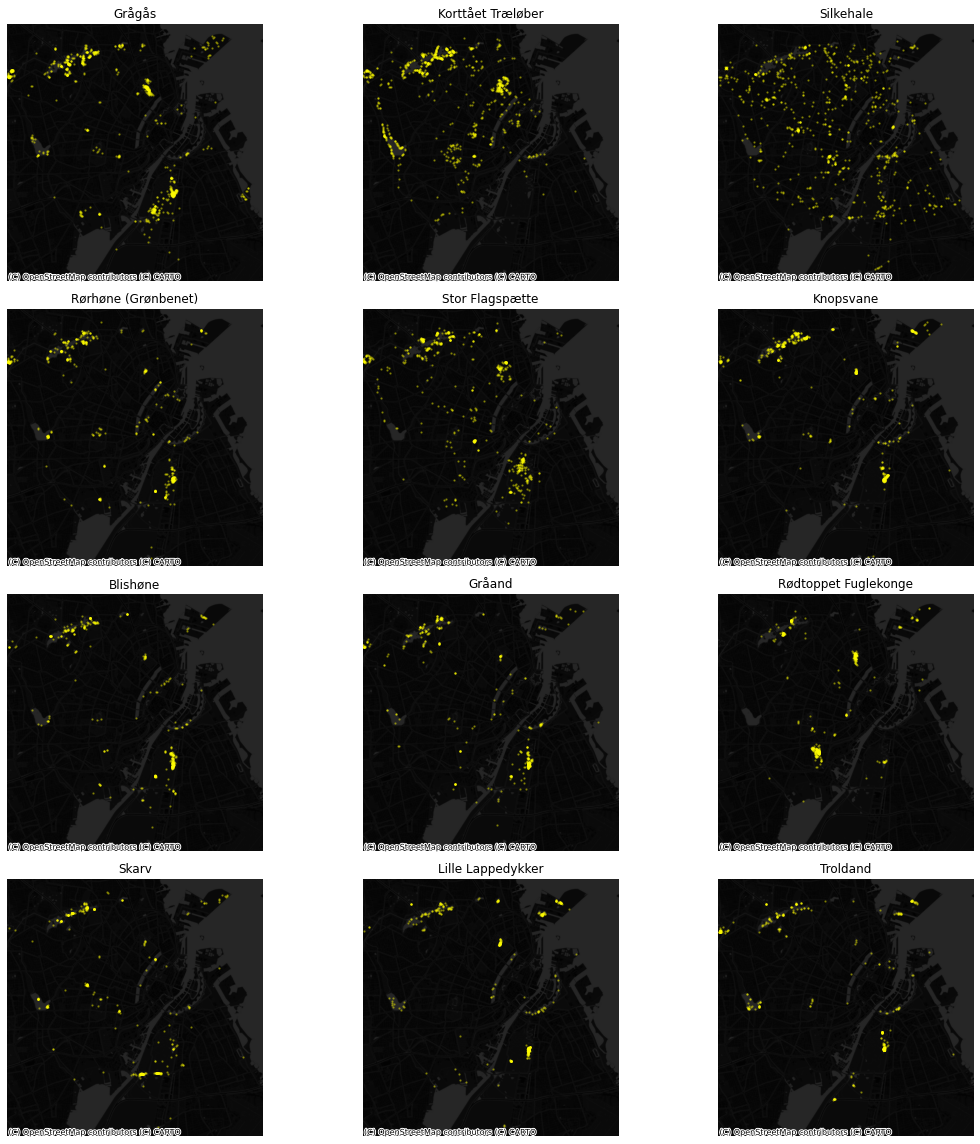

In [22]:
N = 12
bird_types = gdf.Artnavn.value_counts().index.to_list()

f, axes = plt.subplots(int(N/3), 3, figsize=(16,16))
axes = axes.flatten()

minx, miny, maxx, maxy = gdf.geometry.total_bounds

for i in range(N):
    ax = axes[i]
    bird_type = bird_types[i]
    
    type_df = gdf[gdf.Artnavn == bird_type]
    ax.scatter(type_df.geometry.x, type_df.geometry.y, s=2, c="xkcd:bright yellow", alpha=0.3)
    
    ax.set_title(bird_type)
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    ax.set_axis_off()
    
    cx.add_basemap(ax=ax, crs=type_df.crs, source=cx.providers.CartoDB.DarkMatterNoLabels)
    
plt.tight_layout()

### Hexbin

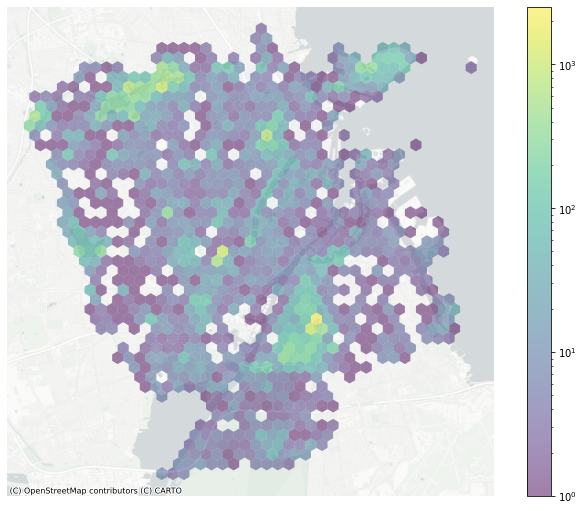

In [23]:
f, ax = plt.subplots(1, figsize=(12, 9))
hb = ax.hexbin(
    gdf.geometry.x, 
    gdf.geometry.y, 
    gridsize=40, 
    alpha=0.5,
    edgecolor="none",
    bins='log',
    mincnt=1
)

plt.colorbar(hb)

cx.add_basemap(source=cx.providers.CartoDB.PositronNoLabels, crs=gdf.crs, ax=ax)
ax.set_axis_off()